## 1. Importation des bibliothèques

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
from sklearn.cluster import KMeans
from scipy.ndimage import uniform_filter1d
import matplotlib.animation as animation
from IPython.display import HTML

## 2. Téléchargement et chargement des données

In [4]:

# Télécharger les données GPCP (précipitations mensuelles)
url = "https://downloads.psl.noaa.gov/Datasets/gpcp/precip.mon.mean.nc"
local_file = "data/gpcp.nc"
urllib.request.urlretrieve(url, local_file)

# Charger le fichier NetCDF
ds_gpcp = xr.open_dataset(local_file)

# Convertir les longitudes 0-360 en -180 à 180
ds_gpcp = ds_gpcp.assign_coords(lon=((ds_gpcp.lon + 180) % 360) - 180).sortby("lon")

# Extraire la région Afrique de l'Ouest (10W–20E, 0–20N)
ds_gpcp = ds_gpcp.sel(lon=slice(-10, 20), lat=slice(0, 20))


### 3. Extraction des précipitations JJA (été)

In [5]:
# Filtrer les mois JJA
precip_JJA = ds_gpcp.precip.where(ds_gpcp['time'].dt.season == 'JJA', drop=True)

# Calcul de la moyenne JJA par année
precip_JJA_annuel = precip_JJA.groupby('time.year').mean('time')

### 4. Calcul des anomalies JJA

In [6]:

# Climatologie de référence (1991-2020)
clim_JJA = precip_JJA_annuel.sel(year=slice(1991, 2020)).mean('year')
anom_JJA = precip_JJA_annuel - clim_JJA

### 5. Chargement de l'indice AMO (AMOC proxy)

In [7]:
url_amo = "https://psl.noaa.gov/data/correlation/amon.us.data"
amo_data = pd.read_csv(url_amo, delim_whitespace=True, header=None, skiprows=1, na_values=-99.990)
amo_data.columns = ["Year"] + [f"Month{m}" for m in range(1,13)]
amo_data = amo_data.set_index("Year").dropna(how='all')
amo_data = amo_data.apply(pd.to_numeric, errors='coerce')  # conversion en float
amo_data.index = amo_data.index.astype(str)  # Assurer que l'index est de type string
amo_jja = amo_data["Month6"].combine(amo_data["Month7"], np.add).combine(amo_data["Month8"], np.add) / 3
amo_jja.name = "AMO_JJA"

# Lissage pour mieux visualiser les variations
amo_jja_clean = amo_jja.dropna()
amo_jja_smooth = pd.Series(uniform_filter1d(amo_jja_clean.values, size=5), index=amo_jja_clean.index)

/var/folders/9_/8zlygvj51hgd9txj3d037_s00000gn/T/ipykernel_71482/347332846.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  amo_data = pd.read_csv(url_amo, delim_whitespace=True, header=None, skiprows=1, na_values=-99.990)


### 6. Analyse régionale : moyenne spatiale

In [8]:
anom_reg = anom_JJA.mean(dim=['lat','lon'])

### 7. Visualisation série temporelle AMO vs pluie

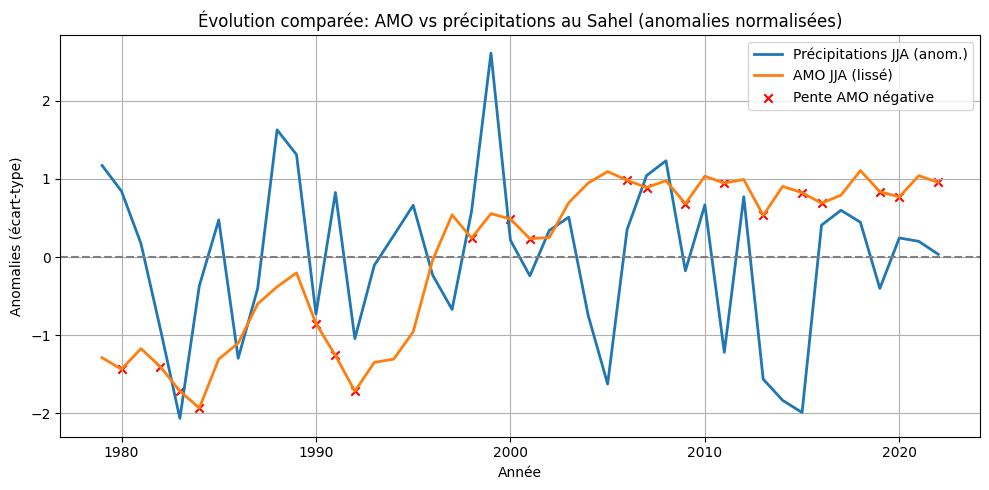

In [9]:
years = anom_reg.year.values.astype(str)
years_available = np.intersect1d(years, amo_jja_clean.index.values)

precip_series = anom_reg.sel(year=years_available.astype(int)).values
amo_vals = amo_jja_clean.loc[years_available].values
amo_smooth_vals = amo_jja_smooth.loc[years_available].values

precip_anom_series = (precip_series - np.mean(precip_series)) / np.std(precip_series)
amo_anom_series = (amo_smooth_vals - np.mean(amo_smooth_vals)) / np.std(amo_smooth_vals)
amo_anom_series_full = amo_anom_series.copy()

# Détection des points où la pente de l'AMO est négative
amo_diff = np.diff(amo_anom_series)
years_int = years_available.astype(int)
x_vals = years_int[1:]
neg_slope_indices = np.where(amo_diff < 0)[0]

plt.figure(figsize=(10,5))
plt.plot(years_int, precip_anom_series, label="Précipitations JJA (anom.)", linewidth=2)
plt.plot(years_int, amo_anom_series_full, label="AMO JJA (lissé)", linewidth=2)
plt.scatter(x_vals[neg_slope_indices], amo_anom_series[1:][neg_slope_indices], color='red', marker='x', label='Pente AMO négative')
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.title("Évolution comparée: AMO vs précipitations au Sahel (anomalies normalisées)")
plt.xlabel("Année")
plt.ylabel("Anomalies (écart-type)")
plt.grid(True)
plt.tight_layout()
plt.show()


### 8. Visualisation du cycle saisonnier moyen

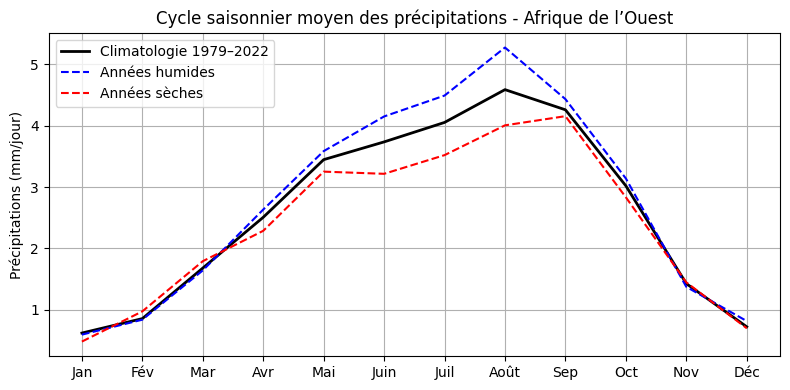

In [10]:
# Étape 1 : Extraction des précipitations JJA par année
precip = ds_gpcp.precip
precip_JJA = precip.where(ds_gpcp['time'].dt.season == 'JJA', drop=True)
precip_JJA_annuel = precip_JJA.groupby('time.year').mean('time')

# Étape 2 : Calcul de la climatologie et des anomalies sur 1991-2020
clim_JJA = precip_JJA_annuel.sel(year=slice(1991, 2020)).mean('year')
anom_JJA = precip_JJA_annuel - clim_JJA

# Étape 3 : Anomalie moyenne régionale par année
anom_reg = anom_JJA.mean(dim=['lat','lon'])

# Seuil = 1 écart-type
threshold = anom_reg.std().item()
years_humides = anom_reg['year'].where(anom_reg > threshold).dropna('year')
years_seches = anom_reg['year'].where(anom_reg < -threshold).dropna('year')

# Étape 4 : Extraire les cycles mensuels pour chaque groupe
# Moyenne spatiale sur toute la région
reg_mean_precip = precip.mean(dim=['lat','lon'])

# Moyenne mensuelle climatologique (toutes les années)
cycle_clim = reg_mean_precip.groupby('time.month').mean('time')

# Moyenne mensuelle pour les années humides et sèches
cycle_humide = reg_mean_precip.sel(time=reg_mean_precip['time'].dt.year.isin(years_humides.values))\
                              .groupby('time.month').mean('time')

cycle_seche = reg_mean_precip.sel(time=reg_mean_precip['time'].dt.year.isin(years_seches.values))\
                             .groupby('time.month').mean('time')

# Étape 5 : Tracer le graphique
months = range(1, 13)
plt.figure(figsize=(8, 4))
plt.plot(months, cycle_clim, label="Climatologie 1979–2022", color='black', linewidth=2)
plt.plot(months, cycle_humide, label="Années humides", color='blue', linestyle='--')
plt.plot(months, cycle_seche, label="Années sèches", color='red', linestyle='--')

plt.xticks(months, ["Jan", "Fév", "Mar", "Avr", "Mai", "Juin", "Juil", "Août", "Sep", "Oct", "Nov", "Déc"])
plt.ylabel("Précipitations (mm/jour)")
plt.title("Cycle saisonnier moyen des précipitations - Afrique de l’Ouest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## Calcul anomalies et années humides/sèches

### Régression AMO vs précip (pas satisfaits)

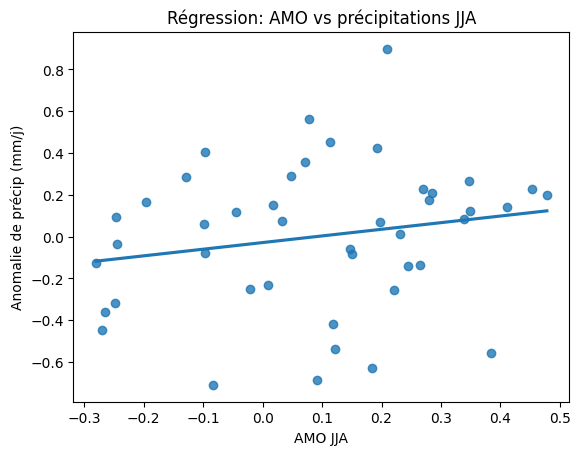

In [9]:
df = pd.DataFrame({'AMO_JJA': amo_vals, 'Precip_anom': precip_series})
sns.regplot(x='AMO_JJA', y='Precip_anom', data=df, ci=None)
plt.title("Régression: AMO vs précipitations JJA")
plt.xlabel("AMO JJA")
plt.ylabel("Anomalie de précip (mm/j)")
plt.show()

### Carte d'une anomalie annuelle

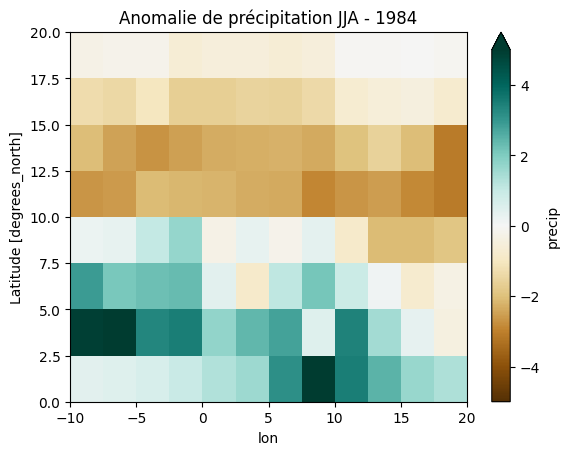

In [10]:
year_to_plot = 1984
anom_map = anom_JJA.sel(year=year_to_plot)
anom_map.plot(cmap="BrBG", vmin=-5, vmax=5)
plt.title(f"Anomalie de précipitation JJA - {year_to_plot}")
plt.show()

### 10. Clustering (classification des années)

In [11]:
X = anom_JJA.values.reshape(anom_JJA.shape[0], -1)
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
labels = kmeans.labels_

# Animation de l'évolution des anomalies par clustering
years_list = anom_JJA.year.values
fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(np.zeros_like(anom_JJA[0].values), origin='lower', extent=[-10, 20, 0, 20], cmap="BrBG", vmin=-5, vmax=5)
title = ax.set_title("")


def update(frame):
    year = years_list[frame]
    label = labels[frame]
    data = anom_JJA.sel(year=year).values
    im.set_data(data)
    title.set_text(f"Année {year} - Cluster {label}")
    return im, title

ani = animation.FuncAnimation(fig, update, frames=len(years_list), interval=300, blit=False)
plt.close()
HTML(ani.to_jshtml())